In [40]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import fsolve
from itertools import permutations

In [41]:
def generate_random_ifs(n_transforms):
    transformations = []
    probabilities = []

    for _ in range(n_transforms):
        a, b = random.uniform(-1, 1), random.uniform(-1, 1)
        c, d = random.uniform(-1, 1), random.uniform(-1, 1)
        e, f = random.uniform(-1, 1), random.uniform(-1, 1)

        transformations.append((a, b, c, d, e, f))
        probabilities.append(random.random())

    total = sum(probabilities)
    probabilities = [p / total for p in probabilities]

    return transformations, probabilities

def generate_self_similar_ifs(n_transforms):
    transformations = []
    probabilities = []

    for _ in range(n_transforms):
        # scale = random.uniform(0.2, 0.7)
        scale = random.uniform(0.2, 0.5)
        angle = random.uniform(0, 2 * math.pi)

        a = scale * math.cos(angle)
        b = -scale * math.sin(angle)
        c = scale * math.sin(angle)
        d = scale * math.cos(angle)

        # e = random.uniform(-1, 1)
        # f = random.uniform(-1, 1)
        e = random.uniform(-0.3, 0.3)
        f = random.uniform(-0.3, 0.3)

        transformations.append((a, b, c, d, e, f))
        probabilities.append(random.random())
    total = sum(probabilities)
    probabilities = [p / total for p in probabilities]

    return transformations, probabilities


def apply_transform(x, y, transform):
    a, b, c, d, e, f = transform
    new_x = a * x + b * y + e
    new_y = c * x + d * y + f
    return new_x, new_y

def generate_fractal(transformations, probabilities, n_points=100000):
    """Generate fractal points using an IFS."""
    x, y = 0, 0
    points = []

    for _ in range(n_points):
        transform = random.choices(transformations, weights=probabilities, k=1)[0]
        x, y = apply_transform(x, y, transform)
        points.append((x, y))

    return points


In [42]:
def calculate_scaling_factors(transformations):
    scaling_factors = []
    for t in transformations:
        a, b, c, d, _, _ = t
        singular_values = np.linalg.svd([[a, b], [c, d]], compute_uv=False)
        scaling_factors.append(max(singular_values))
    return scaling_factors

def similarity_dimension(scaling_factors):
    def equation(D):
        return sum(s ** D for s in scaling_factors) - 1
    D_initial_guess = 1.0
    D_solution = fsolve(equation, D_initial_guess)
    return D_solution[0]

In [43]:
def show_results(transformations, probabilities):
    points = generate_fractal(transformations, probabilities, n_points=100000)

    x_coords, y_coords = zip(*points)

    plt.figure(figsize=(5, 5))
    plt.scatter(x_coords, y_coords, s=0.1, color="black")
    plt.axis("off")
    plt.title("Random Fractal Generated by IFS")
    plt.show()

    scaling_factors = calculate_scaling_factors(transformations)

    dimension = similarity_dimension(scaling_factors)
    print(f"Approximate Fractal Dimension: {dimension:.4f}")

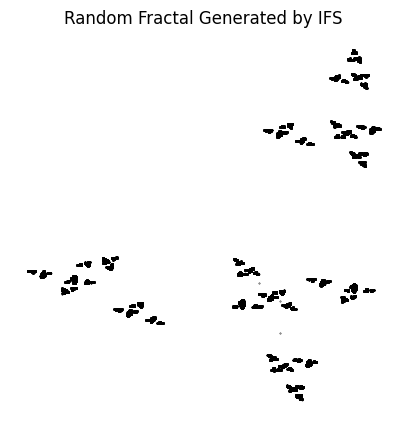

Approximate Fractal Dimension: 0.9993


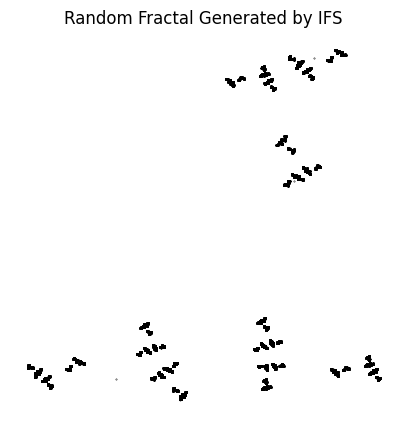

Approximate Fractal Dimension: 0.9321


In [44]:
n_transforms = 3
for i in range(1,3):
    transformations, probabilities = generate_self_similar_ifs(n_transforms)
    show_results(transformations, probabilities)

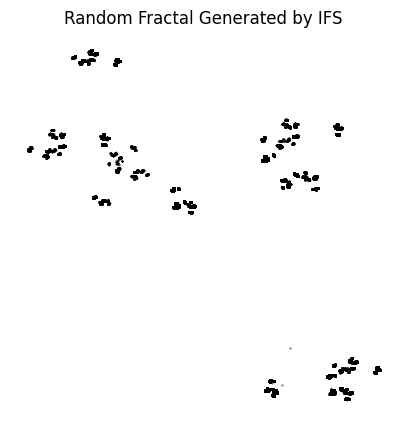

Approximate Fractal Dimension: 0.9565


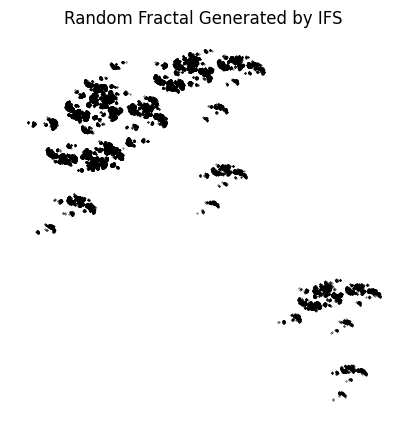

Approximate Fractal Dimension: 1.4186


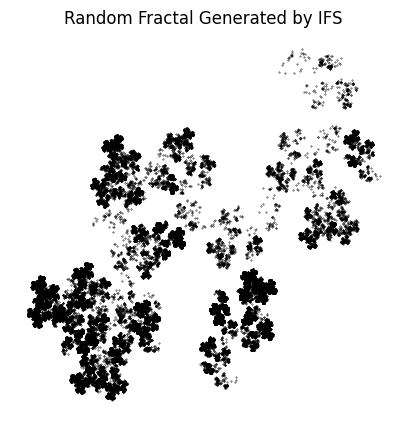

Approximate Fractal Dimension: 1.7747


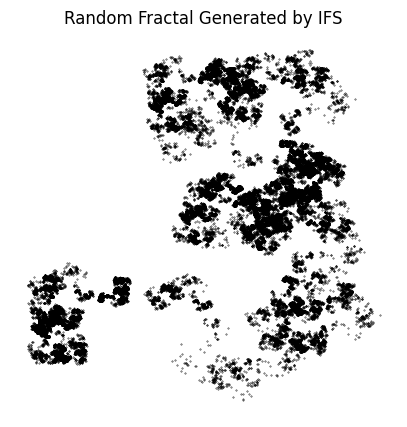

Approximate Fractal Dimension: 1.8957


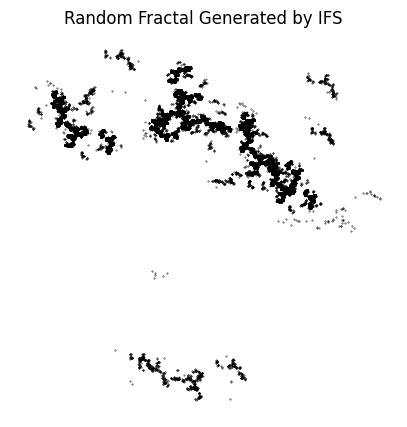

Approximate Fractal Dimension: 1.7226


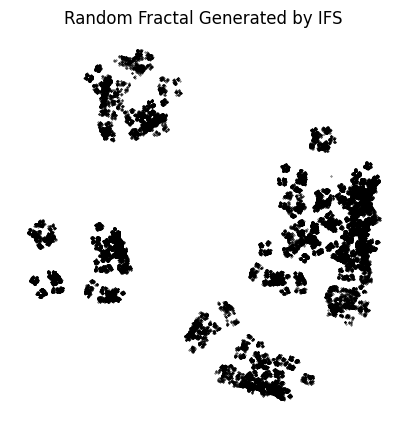

Approximate Fractal Dimension: 1.6777


In [45]:
for i in range(3,9):
    transformations, probabilities = generate_self_similar_ifs(i)
    show_results(transformations, probabilities)

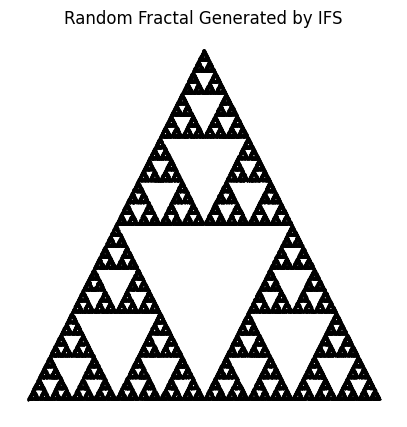

Approximate Fractal Dimension: 1.5850


In [46]:
#SIERPINSKI'S TRIANGLE
#expected dim = 1.585
transformations = [
    (0.5, 0.0, 0.0, 0.5, 0.0, 0.0),
    (0.5, 0.0, 0.0, 0.5, 0.5, 0.0),
    (0.5, 0.0, 0.0, 0.5, 0.25, 0.433),
]
probabilities = [1 / len(transformations)] * len(transformations)
show_results(transformations, probabilities)

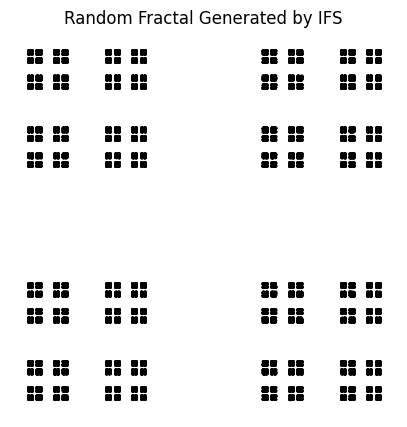

Approximate Fractal Dimension: 1.2619


In [47]:
# CANTOR DUST
# Expected dim = 1.26186
transformations = [
    (1/3, 0.0, 0.0, 1/3, 0.0, 0.0),
    (1/3, 0.0, 0.0, 1/3, 2/3, 0.0),
    (1/3, 0.0, 0.0, 1/3, 0.0, 2/3),
    (1/3, 0.0, 0.0, 1/3, 2/3, 2/3),
]
probabilities = [1 / len(transformations)] * len(transformations)
show_results(transformations, probabilities)

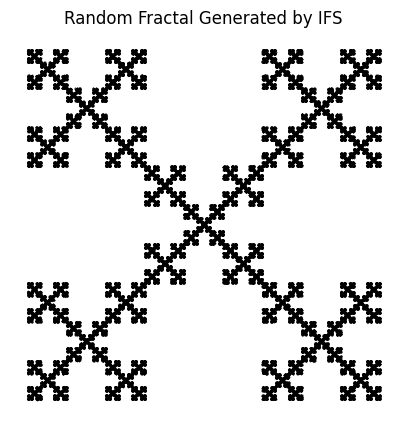

Approximate Fractal Dimension: 1.4650


In [48]:
# VICSEK FRACTAL
# Expected dim = log(5)/log(3) = 1.465
transformations = [
    (1/3, 0.0, 0.0, 1/3, 0.0, 0.0),
    (1/3, 0.0, 0.0, 1/3, 2/3, 0.0),
    (1/3, 0.0, 0.0, 1/3, 1/3, 1/3),
    (1/3, 0.0, 0.0, 1/3, 0.0, 2/3),
    (1/3, 0.0, 0.0, 1/3, 2/3, 2/3),
]
probabilities = [1 / len(transformations)] * len(transformations)
show_results(transformations, probabilities)

Modyfikacje fraktali klasycznych z losowością

Poniższy kod zawiera modyfikację algorytmu generujący Trójkąt Sierpińskiego. Zamiast usuwać środkowy trójkąt, zostaje usunięty trójkąt "górny" względem perspektywy trójkąta. Warto zauważyć, że jesteśmy w stanie taki algorytm zaimplementować na 3! = 6 sposobów (liczba permutacji wierzchołków środkowego trójkąta), co zostało zrandomizowane - za każdym razem ustawienie trójkąta (więc i trójkąt który będziemy usuwać) jest losowane z dostępnej puli permutacji.

In [ ]:
def sierpinski_mod_rand(points, n):
    if n == 0:
        return [points]

    mid1 = ((points[0][0] + points[1][0]) / 2, (points[0][1] + points[1][1]) / 2)
    mid2 = ((points[1][0] + points[2][0]) / 2, (points[1][1] + points[2][1]) / 2)
    mid3 = ((points[0][0] + points[2][0]) / 2, (points[0][1] + points[2][1]) / 2)
    
    perm = permutations([mid1, mid2, mid3]) 
    
    triangles = []
    triangles.extend(sierpinski_mod_rand([points[0], mid1, mid3], n-1))
    triangles.extend(sierpinski_mod_rand([points[1], mid1, mid2], n-1))
    triangles.extend(sierpinski_mod_rand(random.choice(list(perm)), n-1))
    
    return triangles

def sierpinski_mod_to_ifd(triangles):
    transformations = []
    
    for triangle in triangles:
        x0, y0 = triangle[0]
        x1, y1 = triangle[1]
        x2, y2 = triangle[2]
        
        scale_x = (x1 - x0) / 2
        scale_y = (y1 - y0) / 2
        
        tx = (x0 + x1 + x2) / 3
        ty = (y0 + y1 + y2) / 3
        
        transformations.append([scale_x, 0, 0, scale_y, tx, ty])
    
    return transformations

def show_results(triangles):
    transformations = sierpinski_mod_to_ifd(triangles)

    scaling_factors = calculate_scaling_factors(transformations)
    dimension = similarity_dimension(scaling_factors)
    print(f"Approximate Fractal Dimension: {dimension:.4f}")

    fig, ax = plt.subplots(figsize=(8, 8))
    for triangle in triangles:
        triangle = np.array(triangle)
        ax.fill(triangle[:, 0], triangle[:, 1], 'green')
    
    ax.axis('equal')
    ax.axis('off')
    plt.show()

triangles = sierpinski_mod_rand([(0, 0), (1, 0), (0.5, np.sqrt(3)/2)], 2)
show_results(triangles)


In [ ]:
triangles = sierpinski_mod_rand([(0, 0), (1, 0), (0.5, np.sqrt(3)/2)], 5)
show_results(triangles)

In [ ]:
triangles = sierpinski_mod_rand([(0, 0), (1, 0), (0.5, np.sqrt(3)/2)], 10)
show_results(triangles)

W poniższym kodzie klasyczny algorytm dywanu Sierpińskiego został zmodyfikowany tak, aby umożliwić wybór, które kwadraty zostaną zachowane, a które usunięte w kolejnych iteracjach. Modyfikacja ta wprowadza nowy parametr keep_pattern, który pozwala użytkownikowi dostosować wzorzec zachowania lub usunięcia poszczególnych kwadratów w siatce 3x3. Parametr keep_pattern będący binarną reprezentacją pól kwadratu 3x3 (9 bitów) jest za każdym razem losowany (wartość dziesiętna od 0 do 511).

In [ ]:
def sierpinski_carpet_mod_rand(x, y, side_length, n):
    if n == 0:
        return [(x, y, side_length)]
    
    new_side_length = side_length / 3
    carpets = []
    keep_pattern = random.randint(0, 511)
    
    for dx in range(3):
        for dy in range(3):
            square_index = dy * 3 + dx
            if not (keep_pattern & (1 << square_index)):
                continue
            
            new_x = x + dx * new_side_length
            new_y = y + dy * new_side_length
            carpets.extend(sierpinski_carpet_mod_rand(new_x, new_y, new_side_length, n-1))
    
    return carpets

def sierpinski_carpet_mod_to_ifd(carpets):
    transformations = []
    
    for x, y, side_length in carpets:
        scale = side_length
        tx = x
        ty = y
        transformations.append([scale, 0, 0, scale, tx, ty])
    
    return transformations

def show_results(carpets):
    transformations = sierpinski_carpet_mod_to_ifd(carpets)

    scaling_factors = calculate_scaling_factors(transformations)
    dimension = similarity_dimension(scaling_factors)
    print(f"Approximate Fractal Dimension: {dimension:.4f}")

    fig, ax = plt.subplots(figsize=(8, 8))
    for x, y, side_length in carpets:
        square = plt.Rectangle((x, y), side_length, side_length, edgecolor='black', facecolor='green')
        ax.add_patch(square)
    
    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()

carpets = sierpinski_carpet_mod_rand(0, 0, 1, 1)
show_results(carpets)


In [ ]:
carpets = sierpinski_carpet_mod_rand(0, 0, 1, 2)
show_results(carpets)

In [ ]:
carpets = sierpinski_carpet_mod_rand(0, 0, 1, 5)
show_results(carpets)

In [ ]:
carpets = sierpinski_carpet_mod_rand(0, 0, 1, 8)
show_results(carpets)